In [29]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog


In [43]:
df = pd.read_excel("Data.xlsx")
df

,Periodo,ROA,NIM,COC,COF,OPEX,OPEX_EF
0,2019,0.0123,0.0571,0.0199,0.049,0.6,0.5
1,2020,0.0107,0.0524,0.0177,0.046,0.6,0.5
2,2021,0.0138,0.0510,0.0215,0.034,0.6,0.5
3,2022,0.0148,0.0522,0.0154,0.031,0.6,0.5
4,2023,0.0133,0.0523,0.0124,0.041,0.6,0.5
5,2024,0.0136,0.0548,0.0185,0.053,0.6,0.5


In [31]:
COF_promedio = df["COF"].mean()
COF_promedio

0.042333333333333334

In [44]:
# Definir el ROA objetivo
ROA_objetivo = 0.015  # 1.5%

# Calcular los valores promedio de COF y OPEX para la restricción
COF_promedio = df["COF"].mean()
COF_promedio = 0.0355

# Definir la función objetivo: minimizar NIM + COC (costos totales)
c = [1, 1]  # Minimizar NIM y COC

# Restricción corregida: ROA = NIM - COC - COF - OPEX
A_eq = [[1, -1]]  # Modelo para la ecuación NIM - COC
b_eq = [ROA_objetivo + COF_promedio]  # ROA ajustado con costos

# Definir los límites de NIM y COC
bounds = [(0.03, 0.08), (0.0185, 0.03)]  # NIM entre 3% y 8%, COC entre 0.5% y 3%

# Ejecutar la optimización lineal
result_lp = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

# Verificar si la optimización fue exitosa
if result_lp.success:
    # Extraer valores óptimos de NIM y COC
    optimal_NIM_LP, optimal_COC_LP = result_lp.x

    # Calcular el ROA obtenido con los valores óptimos encontrados
    optimal_ROA_LP = optimal_NIM_LP - optimal_COC_LP - COF_promedio

    # Mostrar resultados
    print(f"NIM Óptimo: {optimal_NIM_LP * 100:.2f}%")
    print(f"COC Óptimo: {optimal_COC_LP * 100:.2f}%")
    print(f"ROA Obtenido: {optimal_ROA_LP * 100:.2f}%")

else:
    # Si no se encuentra solución, mostrar el mensaje de error
    print("⚠️ No se encontró una solución óptima.")
    print("Mensaje de error:", result_lp.message)

NIM Óptimo: 6.90%
COC Óptimo: 1.85%
ROA Obtenido: 1.50%


In [39]:
optimal_ROA_LP = 0.0730 - 0.0185 - 0.0395
optimal_ROA_LP

0.014999999999999993

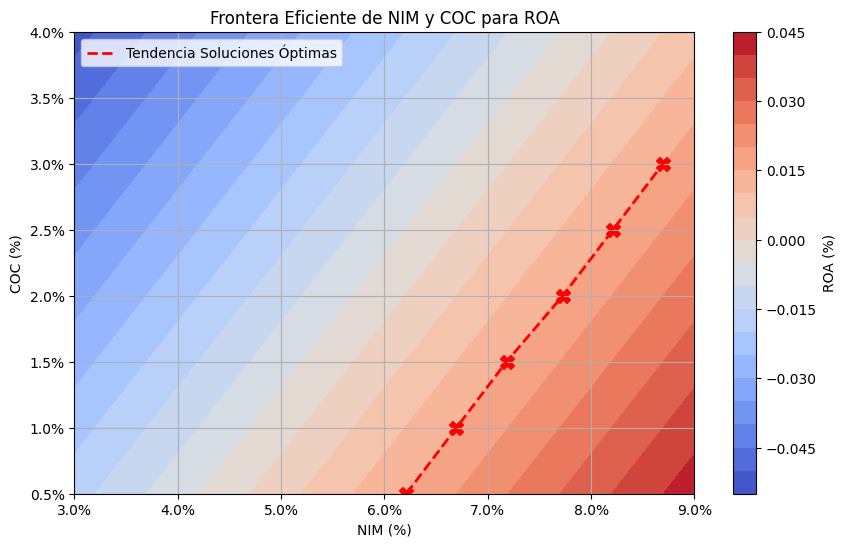

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Definir los valores específicos de COC para la frontera eficiente
coc_values_fixed = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]  # 0.5%, 1%, 1.5%, 2%, 2.5%, 3%
nim_values = np.linspace(0.03, 0.09, 100)  # NIM entre 3% y 9%
coc_extended = np.linspace(0.005, 0.04, 100)  # COC entre 0.5% y 4%

# Promedio de COF (reemplazar con el valor real del dataset)
COF_promedio = 0.042  # Ajustar según datos reales

# Crear una malla de valores de NIM y COC
NIM_grid, COC_grid = np.meshgrid(nim_values, coc_extended)

# Calcular ROA para cada combinación de NIM y COC
ROA_grid = NIM_grid - COC_grid - COF_promedio  # Sin OPEX porque ya está implícito en los datos históricos

# Crear la figura
plt.figure(figsize=(10, 6))

# Graficar la frontera eficiente con contornos de color
contour = plt.contourf(NIM_grid, COC_grid, ROA_grid, levels=20, cmap="coolwarm")
plt.colorbar(contour, label="ROA (%)")

# Marcar los puntos óptimos donde ROA = 1.5% y almacenarlos para la línea de tendencia
optimal_nim = []
optimal_coc = []

for coc in coc_values_fixed:
    roa_values = [nim - coc - COF_promedio for nim in nim_values]
    closest_index = np.argmin(np.abs(np.array(roa_values) - 0.015))
    optimal_nim.append(nim_values[closest_index])
    optimal_coc.append(coc)
    plt.scatter(nim_values[closest_index], coc, color="red", marker="X", s=100)

# Agregar línea de tendencia que conecte las soluciones óptimas
plt.plot(optimal_nim, optimal_coc, color="red", linestyle="--", linewidth=2, label="Tendencia Soluciones Óptimas")

# Formatear los ejes en porcentaje
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

# Ajustar límites de los ejes
plt.xlim(0.03, 0.09)
plt.ylim(0.005, 0.04)

# Etiquetas y leyenda
plt.xlabel("NIM (%)")
plt.ylabel("COC (%)")
plt.title("Frontera Eficiente de NIM y COC para ROA")
plt.legend(loc="upper left")
plt.grid(True)

# Mostrar la gráfica
plt.show()

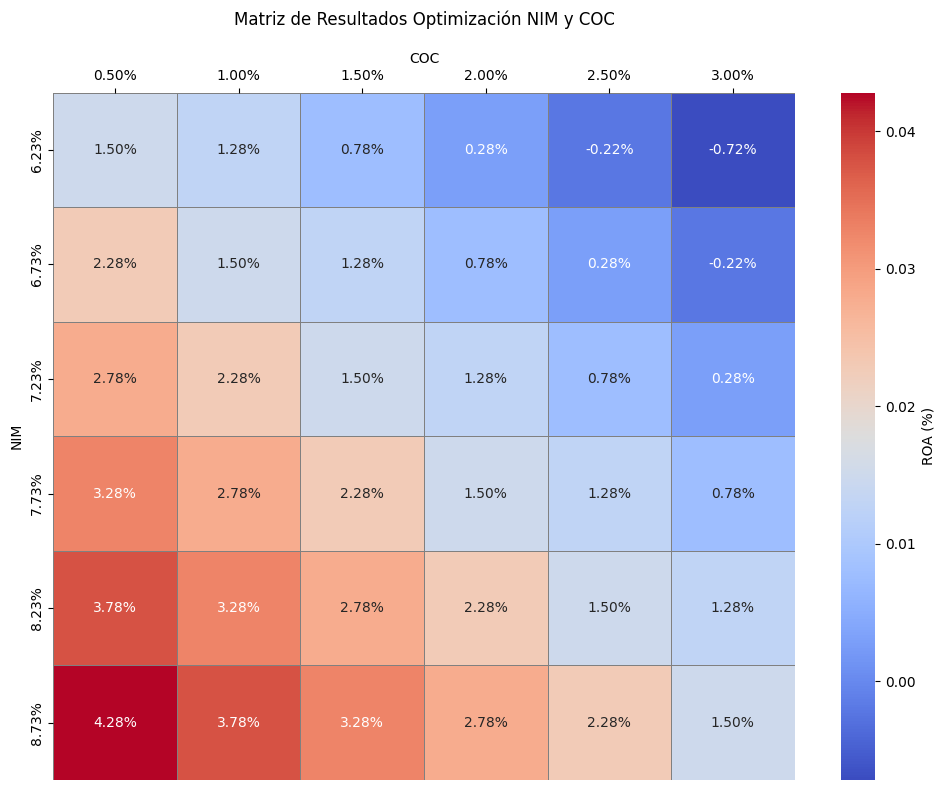

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import seaborn as sns
import matplotlib.pyplot as plt

# Definir niveles específicos para COC
coc_levels = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]

# Preparar matriz vacía para almacenar resultados
resultados = np.zeros((len(coc_levels), len(coc_levels)))

# Calcular NIM óptimo y ROA para cada nivel de COC
nim_levels = np.linspace(0.0623, 0.0873, len(coc_levels))
for i, coc in enumerate(coc_levels):
    # Resolver optimización lineal para cada nivel de COC
    c = [1, 1]  # minimizar NIM + COC
    A_eq = [[1, -1]]
    b_eq = [ROA_objetivo + COF_promedio]
    bounds = [(0.03, 0.09), (coc, coc)]  # Fijar COC en cada iteración

    resultado_opt = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if resultado_opt.success:
        optimal_nim, optimal_coc = resultado_opt.x
        optimal_roa = optimal_nim - optimal_coc - COF_promedio
    else:
        optimal_nim, optimal_roa = np.nan, np.nan

    # Llenar la matriz con ROA calculados para diferentes combinaciones
    for j, nim in enumerate(nim_levels):
        resultados[j, i] = nim - coc - COF_promedio

    # Asignar valor óptimo en la diagonal
    resultados[i, i] = optimal_roa

# Crear DataFrame para visualización clara
df_resultados = pd.DataFrame(resultados, index=[f"{nim:.2%}" for nim in nim_levels], columns=[f"{coc:.2%}" for coc in coc_levels])

# Visualización con heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_resultados, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5, linecolor="gray", cbar_kws={'label': 'ROA (%)'})
ax.xaxis.tick_top()  # Colocar los niveles de COC en la parte superior
ax.xaxis.set_label_position('top')
plt.title("Matriz de Resultados Optimización NIM y COC", pad=20)
plt.xlabel("COC")
plt.ylabel("NIM")
plt.tight_layout()
plt.show()


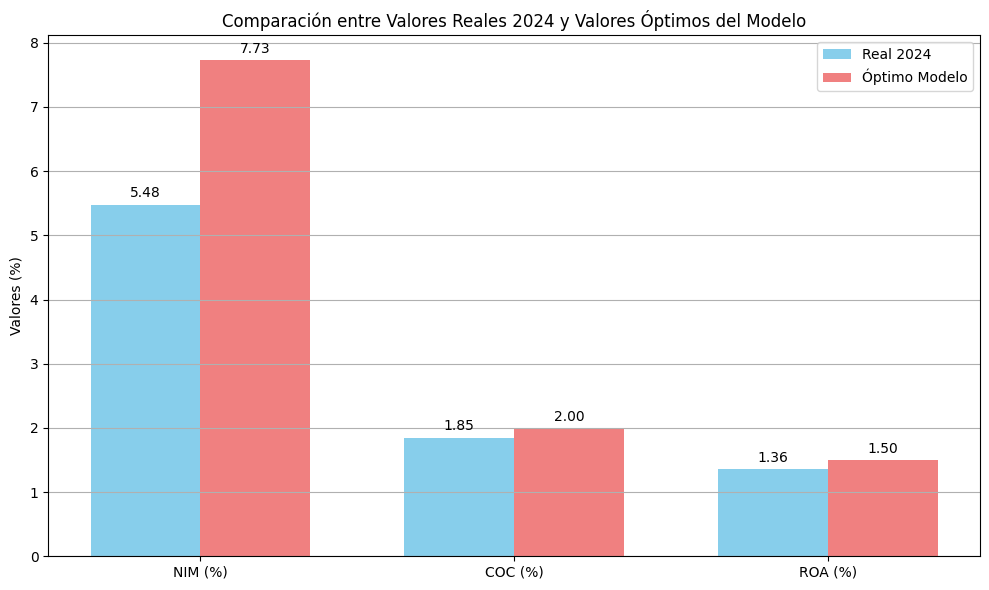

In [8]:
# Reimportar librerías después del reinicio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datos reales del 2024
real_values = {
    "NIM": 5.48,
    "COC": 1.85,
    "ROA": 1.36
}

# Valores óptimos para un COC cercano al real (~2%) según la matriz optimizada
optimal_values = {
    "NIM": 7.73,  # Según matriz optimizada para COC ~2%
    "COC": 2.00,  # Fijado en la optimización
    "ROA": 1.50   # Objetivo del modelo
}

# Calcular diferencias entre valores reales y valores óptimos
difference_values = {
    key: real_values[key] - optimal_values[key] for key in real_values.keys()
}

# Crear DataFrame para mostrar la comparación
df_comparativo = pd.DataFrame([real_values, optimal_values, difference_values],
                              index=["Real 2024", "Óptimo Modelo", "Diferencia"])

# Mostrar la tabla comparativa
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Comparación de Valores Reales vs. Óptimos", dataframe=df_comparativo)

# Graficar la comparación
labels = ["NIM (%)", "COC (%)", "ROA (%)"]
real_vals = list(real_values.values())
optimal_vals = list(optimal_values.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, real_vals, width, label='Real 2024', color='skyblue')
bar2 = ax.bar(x + width/2, optimal_vals, width, label='Óptimo Modelo', color='lightcoral')

# Etiquetas y títulos
ax.set_ylabel("Valores (%)")
ax.set_title("Comparación entre Valores Reales 2024 y Valores Óptimos del Modelo")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Agregar etiquetas a las barras
ax.bar_label(bar1, padding=3, fmt="%.2f")
ax.bar_label(bar2, padding=3, fmt="%.2f")

plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Interpretación


*   El NIM real (5.48%) fue menor que el óptimo (7.73%), lo que afecto el ROA.  
*   El COC real (1.85%) estuvo muy cerca del óptimo (2%)
*   Como resultado, el ROA real (1.36%) fue menor al esperado (1.50%)



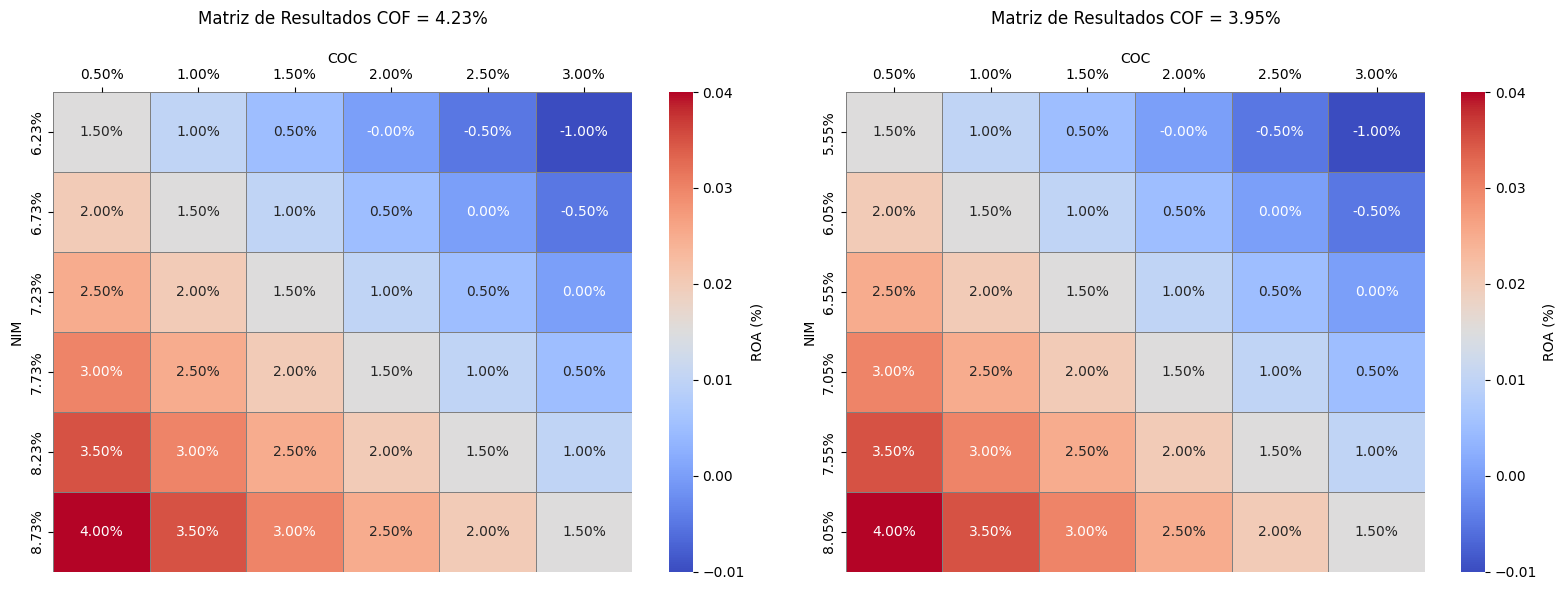

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog

# Definir los dos escenarios de COF promedio
COF_escenarios = [0.0423, 0.0355]
escenario_labels = ["COF = 4.23%", "COF = 3.95%"]
ROA_objetivo = 0.015  # 1.5%

# Definir niveles específicos de COC
coc_levels = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]

# Crear matrices para ambos escenarios
matrices_resultados = {}

for idx, COF_promedio in enumerate(COF_escenarios):
    resultados = np.zeros((len(coc_levels), len(coc_levels)))
    nim_levels = []  # Lista para almacenar los NIM óptimos

    # Calcular NIM óptimo para cada nivel de COC
    for coc in coc_levels:
        c = [1, -1]  # Optimizar NIM - COC
        A_eq = [[1, -1]]
        b_eq = [ROA_objetivo + COF_promedio]
        bounds = [(0.03, 0.09), (coc, coc)]  # Fijar COC en cada iteración

        resultado_opt = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if resultado_opt.success:
            optimal_nim, _ = resultado_opt.x
        else:
            optimal_nim = np.nan

        nim_levels.append(optimal_nim)

    # Crear matriz con cálculos de ROA
    for i, nim in enumerate(nim_levels):
        for j, coc in enumerate(coc_levels):
            resultados[i, j] = nim - coc - COF_promedio
        # Asignar el ROA objetivo en la diagonal
        resultados[i, i] = ROA_objetivo

    # Crear DataFrame con resultados
    matrices_resultados[escenario_labels[idx]] = pd.DataFrame(resultados,
                                                              index=[f"{nim:.2%}" for nim in nim_levels],
                                                              columns=[f"{coc:.2%}" for coc in coc_levels])

# Graficar los heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (label, df) in enumerate(matrices_resultados.items()):
    ax = sns.heatmap(df, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5, linecolor="gray",
                     cbar_kws={'label': 'ROA (%)'}, ax=axes[idx])
    ax.xaxis.tick_top()  # Colocar los niveles de COC en la parte superior
    ax.xaxis.set_label_position('top')
    ax.set_title(f"Matriz de Resultados {label}", pad=20)
    ax.set_xlabel("COC")
    ax.set_ylabel("NIM")

plt.tight_layout()
plt.show()

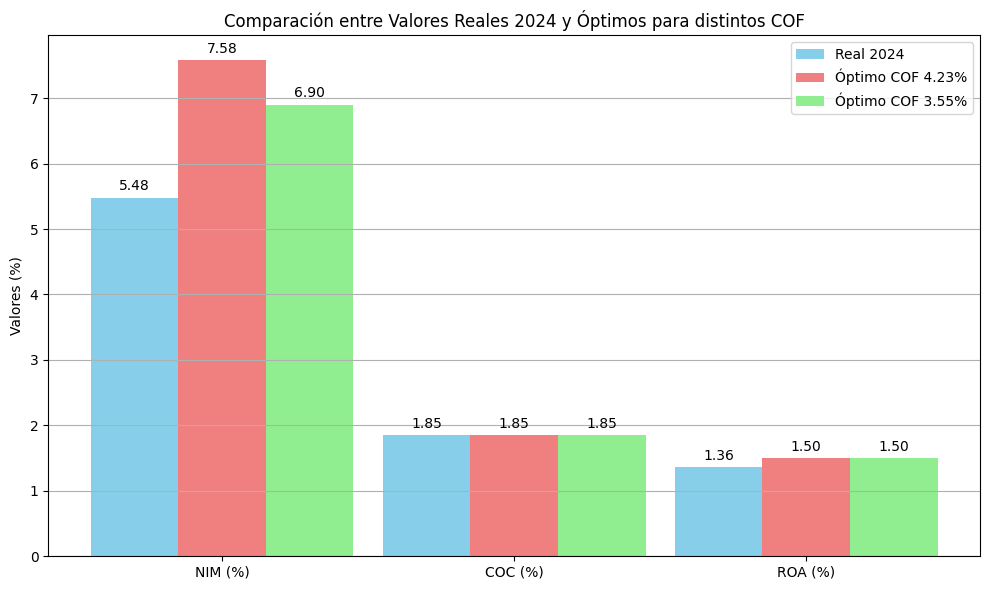

In [45]:
# Datos para los dos escenarios de COF
real_values_2024 = {
    "NIM": 5.48,
    "COC": 1.85,
    "ROA": 1.36
}

# Escenarios con COF = 4.23% y COF = 3.95%
optimal_values_423 = {
    "NIM": 7.58,  # Según matriz optimizada para COC ~2%
    "COC": 1.85,
    "ROA": 1.50
}

optimal_values_395 = {
    "NIM": 6.90,  # Según matriz optimizada para COC ~2%
    "COC": 1.85,
    "ROA": 1.50
}

# Crear gráfico de comparación
labels = ["NIM (%)", "COC (%)", "ROA (%)"]
real_vals = list(real_values_2024.values())
optimal_vals_423 = list(optimal_values_423.values())
optimal_vals_395 = list(optimal_values_395.values())

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, real_vals, width, label='Real 2024', color='skyblue')
bar2 = ax.bar(x, optimal_vals_423, width, label='Óptimo COF 4.23%', color='lightcoral')
bar3 = ax.bar(x + width, optimal_vals_395, width, label='Óptimo COF 3.55%', color='lightgreen')

# Etiquetas y títulos
ax.set_ylabel("Valores (%)")
ax.set_title("Comparación entre Valores Reales 2024 y Óptimos para distintos COF")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Agregar etiquetas a las barras
ax.bar_label(bar1, padding=3, fmt="%.2f")
ax.bar_label(bar2, padding=3, fmt="%.2f")
ax.bar_label(bar3, padding=3, fmt="%.2f")

plt.grid(axis='y')
plt.tight_layout()
plt.show()
